# Using TF Implementation of RNN to Make Predictions

In [4]:
import matplotlib.pyplot as plt

sys.path.append(r'../atm_demand')
from feature_generation import *

from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Importing Data

In [35]:
df = pd.read_csv("../atm_demand/DATA_sample_atm.csv")
targets = ['CashIn', 'CashOut']
atm_df = get_atm(df, 26637)
atm_df = atm_df[:-135]
atm_df = clean_data(atm_df, drop_zeros=True)
feature_set = get_feature_sets(atm_df, ['CashIn', 'CashOut'])

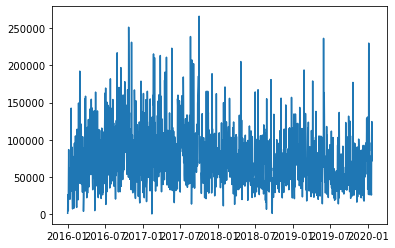

In [36]:
plt.plot(atm_df['CashIn'])

In [37]:
TARGET = 'CashIn'
X_train, X_test, y_train, y_test = train_test_split(feature_set[feature_set.columns[2:]], feature_set[TARGET], shuffle = False)

In [38]:
def get_input_sets(df, feature_groups):
    set_of_features = []
    for group in feature_groups:
        set_of_features.append(df[group])
    return set_of_features

## Baseline Score

I will begin with training a model using past n days of CashIn as input

In [39]:
N_TIMESTEPS = 14
feature_groups = [['%s_t-%d'%(TARGET, i)for i in range(1,N_TIMESTEPS + 1)]]

train_inputs = get_input_sets(X_train, feature_groups)
test_inputs  = get_input_sets(X_test, feature_groups)

In [60]:
# inputs shape = [batch, timesteps, feature]
BATCH = 64
base_input   = layers.Input(shape=(N_TIMESTEPS, 1))
base_rnn     = layers.SimpleRNN(32)(base_input)
base_dropout = layers.Dropout(0.1)(base_rnn)
base_dense1  = layers.Dense(16)(base_dropout)
base_output  = layers.Dense(1)(base_dense1)

base_model = keras.Model(inputs=[base_input], outputs = [base_output])
base_model.summary()

Model: "functional_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 14, 1)]           0         
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 32)                1088      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 17        
Total params: 1,633
Trainable params: 1,633
Non-trainable params: 0
_________________________________________________________________


In [61]:
base_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mape')

In [62]:
history = base_model.fit(train_inputs, 
            y_train,
            batch_size=32,
            epochs=100,
            validation_data=(test_inputs, y_test),
            verbose = 1)

Epoch 1/100
34/34 [==============================] - 0s 8ms/step - loss: 97.5246 - val_loss: 89.4400
Epoch 2/100
34/34 [==============================] - 0s 2ms/step - loss: 86.4584 - val_loss: 65.5983
Epoch 3/100
34/34 [==============================] - 0s 2ms/step - loss: 76.4036 - val_loss: 47.0460
Epoch 4/100
34/34 [==============================] - 0s 2ms/step - loss: 69.7310 - val_loss: 41.4247
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 70.8540 - val_loss: 40.0485
Epoch 6/100
34/34 [==============================] - 0s 2ms/step - loss: 69.1462 - val_loss: 39.8992
Epoch 7/100
34/34 [==============================] - 0s 2ms/step - loss: 68.4968 - val_loss: 39.6359
Epoch 8/100
34/34 [==============================] - 0s 3ms/step - loss: 68.7542 - val_loss: 39.3597
Epoch 9/100
34/34 [==============================] - 0s 3ms/step - loss: 69.2970 - val_loss: 39.3135
Epoch 10/100
34/34 [==============================] - 0s 3ms/step - loss: 69.2881 - val_los

In [63]:
def plot_history(history):
    plt.figure(figsize=(10,4))
    for key in history.history:
        plt.plot(history.history[key], label = key)
    plt.legend()
    plt.show()

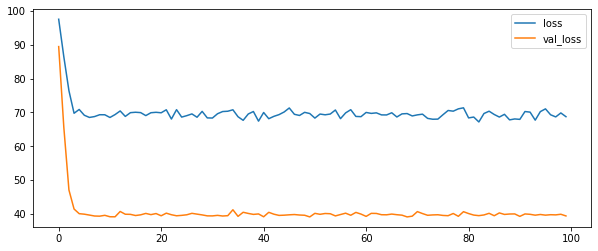

In [64]:
plot_history(history)

In [65]:
"min_loss: %.4f, min_val_loss: %.4f" % (min(history.history['loss']), min(history.history['val_loss']))

'min_loss: 67.1632, min_val_loss: 39.0908'

### Comparing with Previous Methods

| Model | Train Error | Test Error | All Set Error |
| - | - | - | - |
| Base | - | - | 78.8 |
| Random Forest | 23.9 | 47.0 | - |
| LGBM | - | 48.7 | - |
| TF Custom RNN | - | - | 70.7 |
| Keras, PP + Fully Connected (with one dropout layer) | 21.7 | 37.8 | - |
| Keras, PP + Fully Connected (with two dropout layers) | 25.3 | 36.9 | - |
| Keras, RNN + Fully Connected (Baseline) | 67.2 | 39.1 | - |

I am not sure about the cause of the high training error in the base model.